<a href="https://colab.research.google.com/github/omnihola/Deep-learning-Papers/blob/master/Simple%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

**Preset**
====


In [0]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1314
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
NUM_EPOCHS = 100 #批次
BATCH_SIZE = 128 #一批次数量
LATENT_DIM = 75
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

**MNIST**
====

In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


**Model**
====

1. F.function()是函数    返回的是数值，不可以执行
2. nn.Function()是类     返回的是函数，Callable
3. forward方法向前传播，更新数值，返回最终数值





In [0]:

class GAN(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, input_data):
        img_generator = self.generator(input_data)
        return img_generator
    
    def discriminator_forward(self, img_discriminator):
        pred = self.discriminator(img_discriminator)
        return pred.view(-1)

**Initialize**
====

In [0]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate) #generator的方法的参数
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate) #discriminator的方法的参数

**Training**
====

In [6]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train() #开始训练模型
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)


        #
        input_data = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(input_data)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()


        # --------------------------
        # 训练识别器
        # --------------------------        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)

        #记录
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: {:.2f} min'.format((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6893/0.6995
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 5.5828/0.0253
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.7630/0.1076
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.4983/0.1782
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 2.6059/0.0668
Time elapsed: 0.09 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.5775/0.2507
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 2.8934/0.1292
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.9983/0.1897
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 0.8590/0.4892
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.9420/0.5107
Time elapsed: 0.18 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.3344/0.3590
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.5914/0.3099
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.8555/0.2718
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.4341/0.3188
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.2267/0.4119
Time elapsed: 0.27 min
Epoch: 004/100 |

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

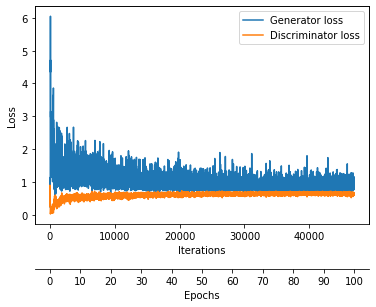

In [22]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis

ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

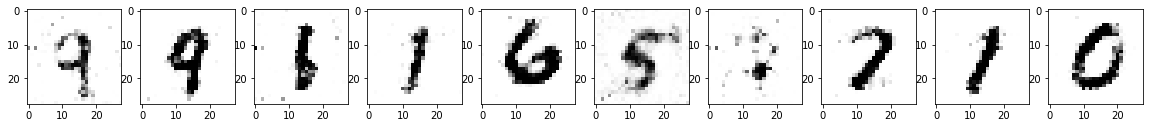

In [15]:
model.eval()
# Make new images
z = torch.zeros((10, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')